In [ ]:
import pandas as pd
import re
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from imblearn.over_sampling import ADASYN
from tensorflow.keras.layers import MultiHeadAttention, Dropout, LayerNormalization, Dense, Input, Embedding, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import classification_report
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('drive/MyDrive/Phishing_Email.csv')

In [ ]:
print(df.columns)

Index(['Unnamed: 0', 'Email Text', 'Email Type'], dtype='object')


In [ ]:
df.head(5)

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18650 entries, 0 to 18649
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  18650 non-null  int64 
 1   Email Text  18634 non-null  object
 2   Email Type  18650 non-null  object
dtypes: int64(1), object(2)
memory usage: 437.2+ KB


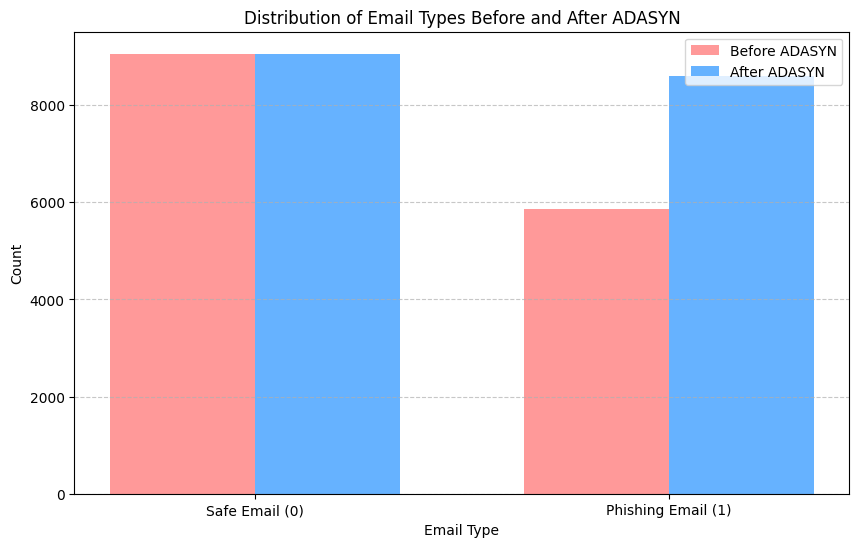

In [ ]:
# Làm sạch văn bản
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'<.*?>', ' ', text)  # Remove HTML tags
    text = re.sub(r'http[s]?://\S+', ' url ', text)  # Replace URLs
    text = re.sub(r'\b[\w\.-]+@[\w\.-]+\.\w+\b', ' email ', text)  # Replace email addresses
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    return text

df['Email Text'] = df['Email Text'].apply(clean_text)

# Giữ lại các nhãn hợp lệ
df = df[df['Email Type'].isin(['Phishing Email', 'Safe Email'])].copy()
df['label'] = df['Email Type'].map({'Phishing Email': 1, 'Safe Email': 0})

# Tokenization
MAX_WORDS = 20000
MAX_LEN = 200
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df['Email Text'])
X_seq = tokenizer.texts_to_sequences(df['Email Text'])
X_pad = pad_sequences(X_seq, maxlen=MAX_LEN, padding='post', truncating='post')
y = np.array(df['label'])

# Chia tập train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_pad, y, test_size=0.2, random_state=42, stratify=y
)

# Áp dụng ADASYN
adasyn = ADASYN(random_state=42, sampling_strategy='minority')
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

# Đếm số lượng mẫu trước và sau ADASYN
labels = ['Safe Email (0)', 'Phishing Email (1)']
before_counts = np.bincount(y_train)
after_counts = np.bincount(y_train_resampled)

# Vẽ biểu đồ cột
plt.figure(figsize=(10, 6))
bar_width = 0.35
x = np.arange(len(labels))

plt.bar(x - bar_width/2, before_counts, bar_width, label='Before ADASYN', color='#FF9999')
plt.bar(x + bar_width/2, after_counts, bar_width, label='After ADASYN', color='#66B2FF')

plt.xlabel('Email Type')
plt.ylabel('Count')
plt.title('Distribution of Email Types Before and After ADASYN')
plt.xticks(x, labels)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
print("Tổng số email:", len(df))
print("Kích thước X_pad:", X_pad.shape)
print("Kích thước y:", y.shape)


Tổng số email: 18650
Kích thước X_pad: (18650, 200)
Kích thước y: (18650,)


In [ ]:
#Function to create positional encoding

def positional_encoding(position, d_model):
    angle_rads = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)


In [ ]:
def transformer_block(inputs, embed_dim, num_heads, ff_dim, rate=0.5):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, kernel_regularizer=regularizers.l2(1e-2))(inputs, inputs)
    attn_output = Dropout(rate)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)
    ffn = Dense(ff_dim, kernel_regularizer=regularizers.l2(1e-2))(out1)
    ffn = tf.keras.layers.ReLU()(ffn)
    ffn = Dense(embed_dim, kernel_regularizer=regularizers.l2(1e-2))(ffn)
    ffn = Dropout(rate)(ffn)
    return LayerNormalization(epsilon=1e-6)(out1 + ffn)

In [ ]:
from tensorflow.keras import regularizers
# 7. Build model
def build_model(maxlen, vocab_size, embed_dim, num_heads, ff_dim, num_blocks=2, dropout_rate=0.3):
    inputs = Input(shape=(maxlen,))
    x = Embedding(input_dim=vocab_size, output_dim=embed_dim)(inputs)
    x = LayerNormalization(epsilon=1e-6)(x)
    pos_encoding = positional_encoding(maxlen, embed_dim)
    x += pos_encoding[:, :maxlen, :]
    for _ in range(num_blocks):
        x = transformer_block(x, embed_dim, num_heads, ff_dim, rate=dropout_rate)
    x = GlobalAveragePooling1D()(x)  # Use average pooling
    x = Dropout(dropout_rate)(x)
    x = Dense(64, kernel_regularizer=regularizers.l2(1e-4))(x)
    x = tf.keras.layers.ReLU()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=[Precision(name='precision'), Recall(name='recall')])
    return model

In [ ]:
# 8. Define model parameters
vocab_size = min(len(tokenizer.word_index) + 1, MAX_WORDS)
maxlen = MAX_LEN
embed_dim = 128
num_heads = 6
ff_dim = 512
dropout_rate = 0.2

In [ ]:
# 9. Build and train model
model = build_model(maxlen, vocab_size, embed_dim, num_heads, ff_dim)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 128)  │  2,560,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 200, 128)  │        256 │ embedding[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 200, 128)  │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 128)  │    395,648 │ add[0][0],        │
│ (MultiHeadAttentio… │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 200, 128)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 200, 128)  │          0 │ add[0][0],        │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 128)  │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 200, 512)  │     66,048 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 200, 512)  │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 200, 128)  │     65,664 │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 200, 128)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 200, 128)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 128)  │        256 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 128)  │    395,648 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 200, 128)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 200, 128)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 128)  │        256 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 200, 512)  │     66,048 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 3,624,321 (13.83 MB)

 Trainable params: 3,624,321 (13.83 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.005, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)
# Train
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 34s 47ms/step - loss: 9.7093 - precision: 0.6298 - recall: 0.4144 - val_loss: 4.8131 - val_precision: 0.9498 - val_recall: 0.9378 - learning_rate: 1.0000e-04
Epoch 2/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - loss: 3.9890 - precision: 0.9441 - recall: 0.9548 - val_loss: 2.1445 - val_precision: 0.9526 - val_recall: 0.9790 - learning_rate: 1.0000e-04
Epoch 3/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - loss: 1.7807 - precision: 0.9663 - recall: 0.9783 - val_loss: 1.0252 - val_precision: 0.9803 - val_recall: 0.9202 - learning_rate: 1.0000e-04
Epoch 4/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - loss: 0.8440 - precision: 0.9749 - recall: 0.9826 - val_loss: 0.5465 - val_precision: 0.9822 - val_recall: 0.9252 - learning_rate: 1.0000e-04
Epoch 5/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - loss: 0.4372 - precision: 0.9761 - recall: 0.9822 - val_loss: 0.3186 - val_precision: 0.9603 - val_recall: 0.9765 - learning_rate: 1.0000e-04
Epoch 6/50

In [ ]:
!pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=5179e56fb162583ccde9735e13200ca9f84a3dc02a55e00a06022eeffd184c01
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
def predict_fn(texts):
    # Chuyển text → sequence → padding
    seqs = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(seqs, maxlen=MAX_LEN, padding='post', truncating='post')
    preds = model.predict(padded)
    # Trả về xác suất cho cả 2 lớp: [P(Safe), P(Phishing)]
    return np.hstack([1 - preds, preds])  # lớp 0 là "Safe", lớp 1 là "Phishing"


In [ ]:
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=["Safe", "Phishing"])

# Chọn email đầu tiên để giải thích
i = 3
text_sample = df['Email Text'].iloc[i]

exp = explainer.explain_instance(
    text_sample,
    predict_fn,
    num_features=10
)

exp.show_in_notebook()


157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step


117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step
                precision    recall  f1-score   support

    Safe Email       0.98      0.96      0.97      2264
Phishing Email       0.95      0.96      0.96      1466

      accuracy                           0.96      3730
     macro avg       0.96      0.96      0.96      3730
  weighted avg       0.96      0.96      0.96      3730



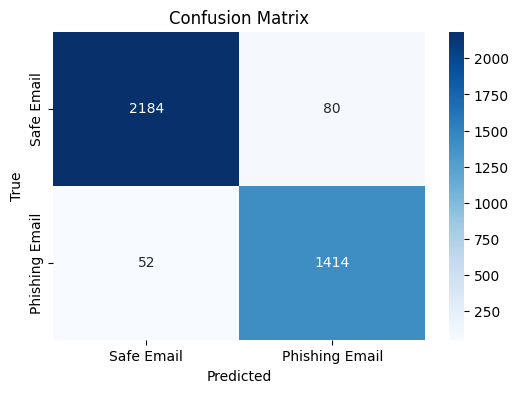

117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step


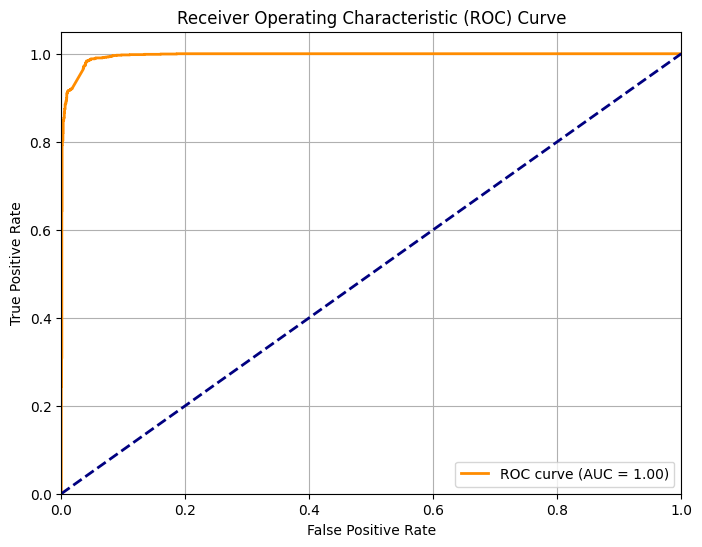

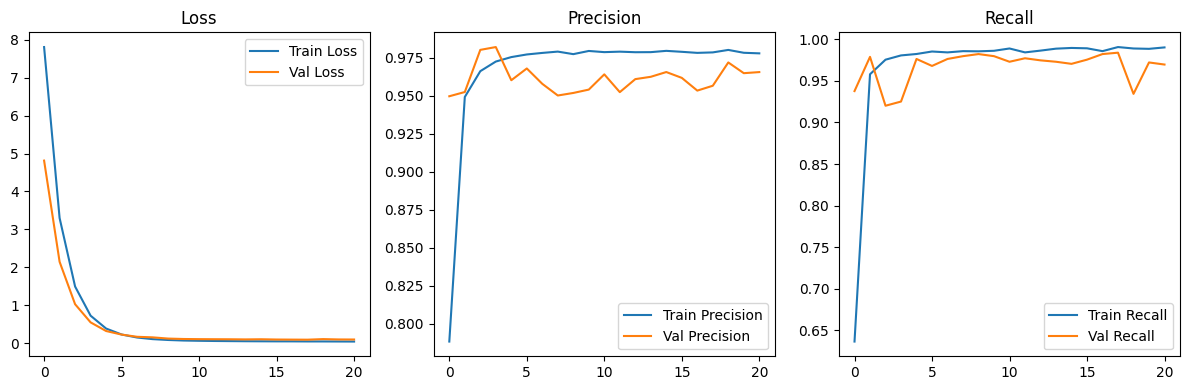

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
# 14. Đánh giá mô hình
y_pred = (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_pred, target_names=['Safe Email', 'Phishing Email']))

# 15. Vẽ Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Safe Email', 'Phishing Email'], yticklabels=['Safe Email', 'Phishing Email'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 16. Vẽ ROC Curve
y_pred_prob = model.predict(X_test).ravel()  # Dự đoán xác suất
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 17. Vẽ biểu đồ Loss, Precision, Recall
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Val Precision')
plt.title('Precision')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Val Recall')
plt.title('Recall')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/BTL_model.keras')

In [ ]:
from tensorflow import keras

model1 = keras.models.load_model('/content/drive/MyDrive/BTL_model.keras')
